In [1]:
#default_exp data_3000L

In [2]:
%reload_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [3]:
#export
from fastai.vision import *
from fastai.callbacks import SaveModelCallback, EarlyStoppingCallback, CSVLogger
from CinemaNet.train_utils import *
from CinemaNet.custom_head import *
from CinemaNet.wandb import *
from CinemaNet.MixMatch import *

import wandb

In [3]:
model_name = 'MNetV2-100x177-3000L'

In [4]:
#hide
wandb.init(name='MNetV2-100x177',
           project='Shot Framing -- Supervised (3000L)',
           tags=['MobileNetV2'],
           entity='synopsis',
           reinit=True)

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
Error generating diff: Command '['git', 'diff', '--submodule=diff', '747359307a168f411ffb9fcfe9d768f1d7920bfd']' timed out after 5 seconds


W&B Run: https://app.wandb.ai/synopsis/Shot+Framing+--+Supervised+%283000L%29/runs/smlfztc7

In [4]:
#hide
%env WANDB_NOTEBOOK_NAME='mixmatch-resnet.ipynb'

env: WANDB_NOTEBOOK_NAME='mixmatch-resnet.ipynb'


## Setup

### Dataset

In [10]:
#export
path = Path('/home/rahul/github_projects/CinemaNet/')

def get_labels(f):
    if re.search(f"{regex['EWS']}", str(f)): return 'Extreme Wide'
    if re.search(f"{regex['LS']}",  str(f)): return 'Long'
    if re.search(f"{regex['MS']}",  str(f)): return 'Medium'
    if re.search(f"{regex['MCU']}", str(f)): return 'Medium Close-Up'
    if re.search(f"{regex['CU']}",  str(f)): return 'Close-Up'
    if re.search(f"{regex['ECU']}", str(f)): return 'Extreme Close-Up'

In [11]:
#export
il_train = ImageList.from_folder(path/'train', presort=True)
il_valid = ImageList.from_folder(path/'valid', presort=True)
regex = {
    'CU' : '\/Close\-Up\/',
    'ECU': '\/Extreme Close\-Up\/',
    'EWS': '\/Extreme Wide\/',
    'LS' : '\/Long\/',
    'MS' : '\/Medium\/',
    'MCU': '\/Medium Close\-Up\/'
}

In [12]:
len(il_train.items)
len(il_valid.items)

5505

600

In [13]:
#export
fnames_all   = list(il_train.items) + list(il_valid.items)
count        = {}
train_fnames = {}
samples_per_label = 500


for key in regex:
    i=0
    train_fnames[key] = []
    for f in fnames_all:
        if re.search(f"{regex[key]}.*", str(f)):
            i+=1
            count[key] = i
            train_fnames[key].append(f)
            if i >= samples_per_label: break; 
count

{'CU': 500, 'ECU': 500, 'EWS': 500, 'LS': 500, 'MS': 500, 'MCU': 500}

In [14]:
#export
fnames_train = sum(train_fnames.values(),[])
fnames_valid = list(set(fnames_all) - set(fnames_train))

In [15]:
len(fnames_train), len(fnames_valid)

(3000, 3105)

In [16]:
#export
lls = LabelLists(path,
                 train=ImageList(fnames_train),
                 valid=ImageList(fnames_valid))

In [17]:
img_size   = to_film_ar(100)
batch_size = 64

In [20]:
#export
def get_data_3000L(img_size, tfms=get_transforms(max_zoom=1.), batch_size=64):
    data = (lls
            .label_from_func(get_labels)
            .transform(tfms=get_transforms(max_zoom=1.),
                       size=img_size,
                       resize_method=ResizeMethod.SQUISH)
            .databunch(bs=batch_size).normalize(imagenet_stats))
    return data

In [23]:
data = get_data_3000L(img_size)
data

ImageDataBunch;

Train: LabelList (3000 items)
x: ImageList
Image (3, 100, 177),Image (3, 100, 177),Image (3, 100, 177),Image (3, 100, 177),Image (3, 100, 177)
y: CategoryList
Close-Up,Close-Up,Close-Up,Close-Up,Close-Up
Path: .;

Valid: LabelList (3105 items)
x: ImageList
Image (3, 100, 177),Image (3, 100, 177),Image (3, 100, 177),Image (3, 100, 177),Image (3, 100, 177)
y: CategoryList
Extreme Wide,Extreme Wide,Extreme Wide,Close-Up,Extreme Wide
Path: .;

Test: None

6

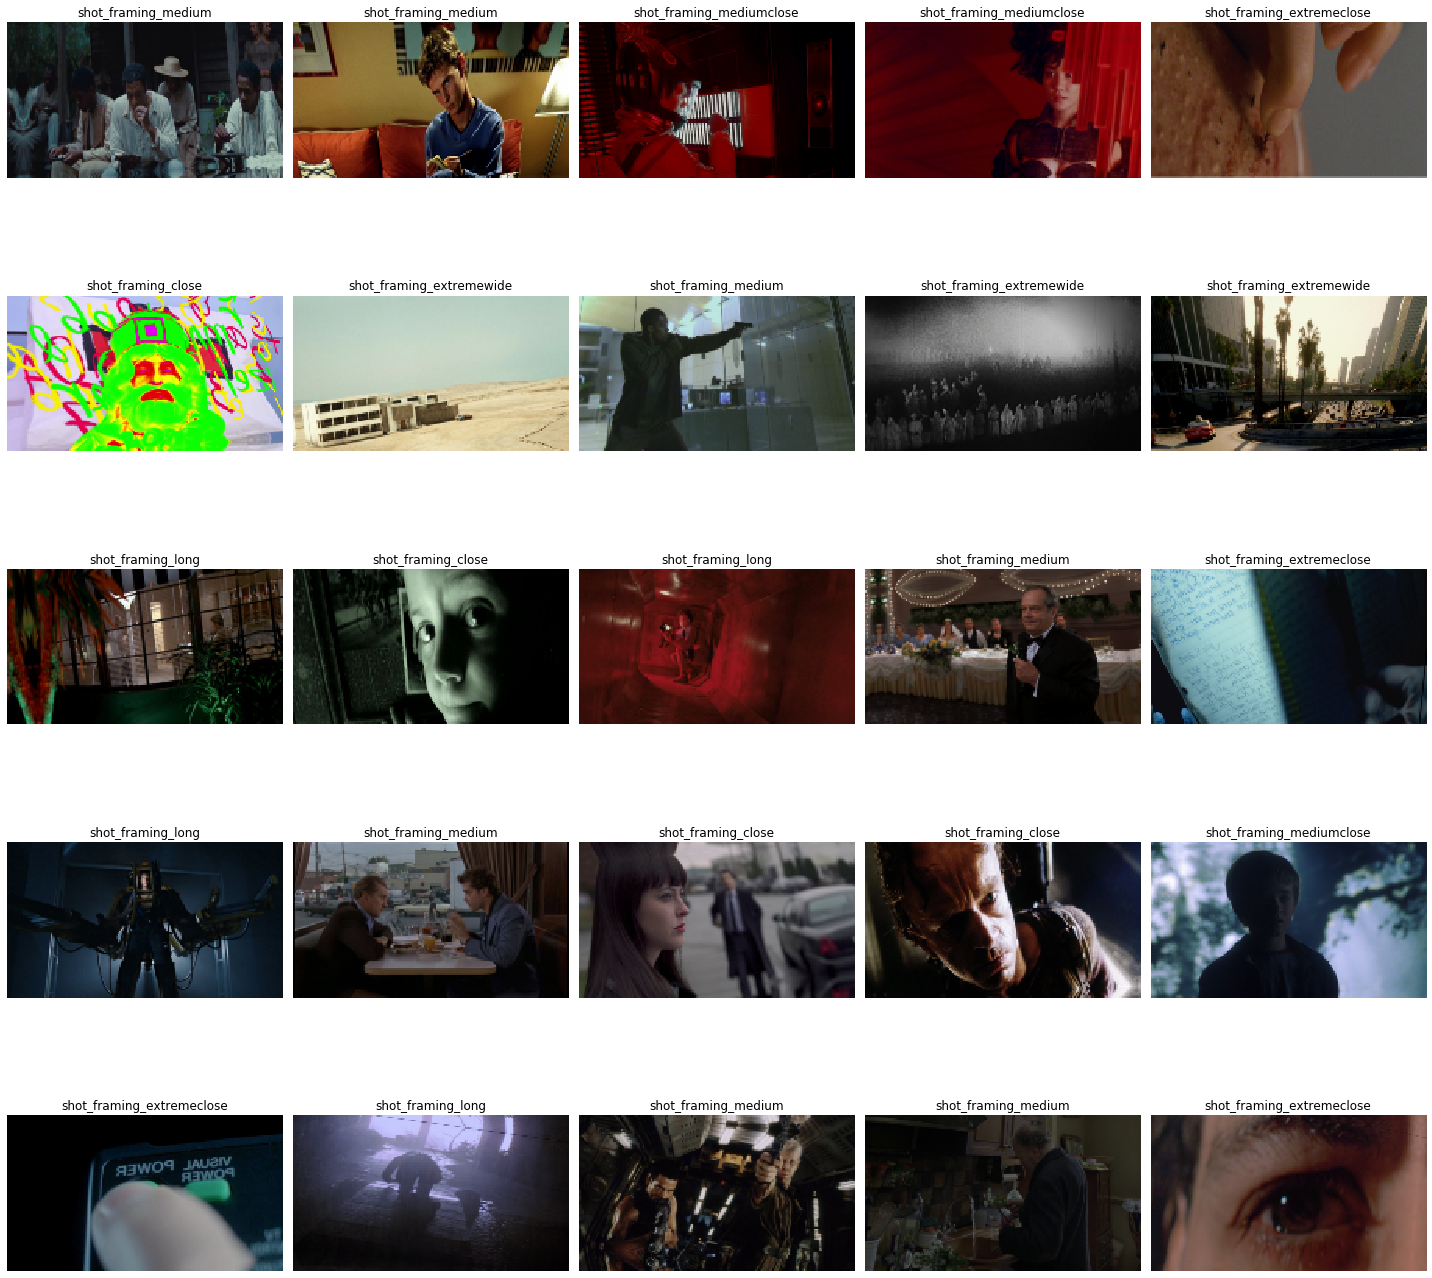

In [20]:
data.c
data.show_batch()

## Training (100, 177)

### Frozen -- Head Only

In [16]:
arch = models.mobilenet_v2
learn = cnn_learner(data, arch, pretrained=True,
                    metrics=metrics)

In [17]:
learn.data

ImageDataBunch;

Train: LabelList (3000 items)
x: ImageList
Image (3, 100, 177),Image (3, 100, 177),Image (3, 100, 177),Image (3, 100, 177),Image (3, 100, 177)
y: CategoryList
Close-Up,Close-Up,Close-Up,Close-Up,Close-Up
Path: .;

Valid: LabelList (3105 items)
x: ImageList
Image (3, 100, 177),Image (3, 100, 177),Image (3, 100, 177),Image (3, 100, 177),Image (3, 100, 177)
y: CategoryList
Medium,Close-Up,Medium,Medium,Close-Up
Path: .;

Test: None

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


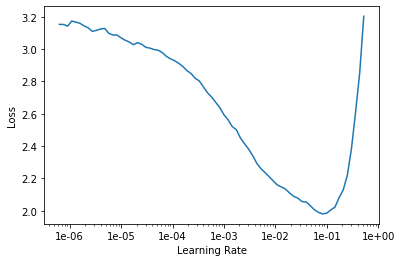

In [18]:
learn.lr_find()
learn.recorder.plot()

In [19]:
def get_callbacks(learner, mod_name, early_stop=True, patience=5, monitor='accuracy', min_delta=0.01):
    callbacks=[
        SaveModelCallback(learner, every='improvement', name=f'{mod_name}', monitor=monitor),
        CSVLogger        (learner, filename=f'{mod_name}-history'),
        WandbCallback    (learner, monitor=monitor, input_type='images', log='all')
    ]
    if early_stop: callbacks.append(EarlyStoppingCallback(learner, patience=patience, min_delta=min_delta, monitor=monitor))
    return callbacks

In [20]:
model_name = 'MNetV2-100x177-3000L'
callbacks = get_callbacks(learn, model_name)

In [22]:
len(learn.layer_groups)

3

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,1.870342,0.833146,0.695008,0.706177,0.729366,00:38
1,1.237836,0.752943,0.746538,0.757545,0.764254,00:37
2,0.880370,0.633866,0.783897,0.791102,0.817789,00:40
3,0.689028,0.542485,0.803543,0.803615,0.823428,00:40
4,0.546626,0.526810,0.809018,0.807400,0.828457,00:40
5,0.451254,0.518122,0.810950,0.811039,0.829890,00:41


Error generating diff: Command '['git', 'diff', '--submodule=diff', '747359307a168f411ffb9fcfe9d768f1d7920bfd']' timed out after 5 seconds
/home/rahul/fastai/fastai/metrics.py:191: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")


Better model found at epoch 0 with accuracy value: 0.6950080394744873.
Better model found at epoch 0 with accuracy value: 0.6950080394744873.
Better model found at epoch 1 with accuracy value: 0.7465378642082214.
Better model found at epoch 1 with accuracy value: 0.7465378642082214.
Better model found at epoch 2 with accuracy value: 0.7838969230651855.
Better model found at epoch 2 with accuracy value: 0.7838969230651855.
Better model found at epoch 3 with accuracy value: 0.8035426735877991.
Better model found at epoch 3 with accuracy value: 0.8035426735877991.
Better model found at epoch 4 with accuracy value: 0.8090177178382874.
Better model found at epoch 4 with accuracy value: 0.8090177178382874.
Better model found at epoch 5 with accuracy value: 0.8109501004219055.
Better model found at epoch 5 with accuracy value: 0.8109501004219055.
Loaded best saved model from /home/rahul/github_projects/CinemaNet/nbs/wandb/run-20200120_193037-smlfztc7/bestmodel.pth


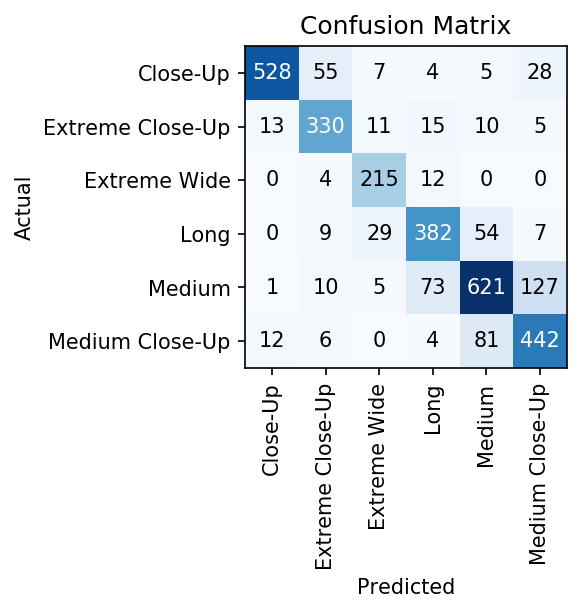

In [23]:
learn.fit_one_cycle(6, 1e-3, callbacks=callbacks)

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,0.410732,0.553005,0.809018,0.811102,0.833362,00:42
1,0.438458,0.555408,0.810628,0.820053,0.827741,00:36
2,0.410100,0.510208,0.819646,0.822099,0.837116,00:35
3,0.377464,0.526723,0.816425,0.813574,0.835150,00:36


Better model found at epoch 0 with accuracy value: 0.8090177178382874.
Better model found at epoch 0 with accuracy value: 0.8090177178382874.


Error generating diff: Command '['git', 'diff', '--submodule=diff', '747359307a168f411ffb9fcfe9d768f1d7920bfd']' timed out after 5 seconds


Better model found at epoch 1 with accuracy value: 0.8106279969215393.
Better model found at epoch 1 with accuracy value: 0.8106279969215393.
Better model found at epoch 2 with accuracy value: 0.8196457624435425.
Better model found at epoch 2 with accuracy value: 0.8196457624435425.
Loaded best saved model from /home/rahul/github_projects/CinemaNet/nbs/wandb/run-20200120_193037-smlfztc7/bestmodel.pth


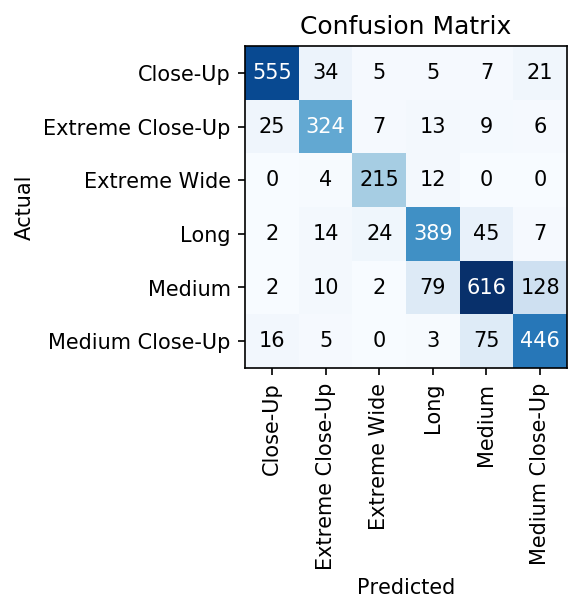

In [24]:
learn.fit_one_cycle(4, slice(1e-3), callbacks=callbacks)

### Unfrozen

In [26]:
learn.unfreeze()
model_name = 'MNetV2-100x177-3000L-unfrozen'
callbacks = get_callbacks(learn, model_name)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


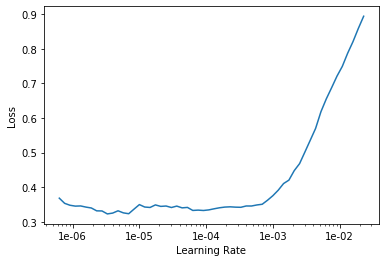

In [27]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,0.340619,0.517755,0.819324,0.819079,0.837887,00:35
1,0.335073,0.507600,0.821900,0.821281,0.839526,00:41
2,0.305376,0.495585,0.828019,0.830046,0.842489,00:39
3,0.306975,0.511917,0.816747,0.823065,0.836070,00:39
4,0.301737,0.513061,0.812560,0.816677,0.830294,00:40
5,0.280614,0.500778,0.823833,0.826517,0.838218,00:38


Better model found at epoch 0 with accuracy value: 0.8193236589431763.
Better model found at epoch 0 with accuracy value: 0.8193236589431763.


Error generating diff: Command '['git', 'diff', '--submodule=diff', '747359307a168f411ffb9fcfe9d768f1d7920bfd']' timed out after 5 seconds


Better model found at epoch 1 with accuracy value: 0.8219001889228821.
Better model found at epoch 1 with accuracy value: 0.8219001889228821.
Better model found at epoch 2 with accuracy value: 0.8280193209648132.
Better model found at epoch 2 with accuracy value: 0.8280193209648132.
Epoch 6: early stopping
Loaded best saved model from /home/rahul/github_projects/CinemaNet/nbs/wandb/run-20200120_193037-smlfztc7/bestmodel.pth


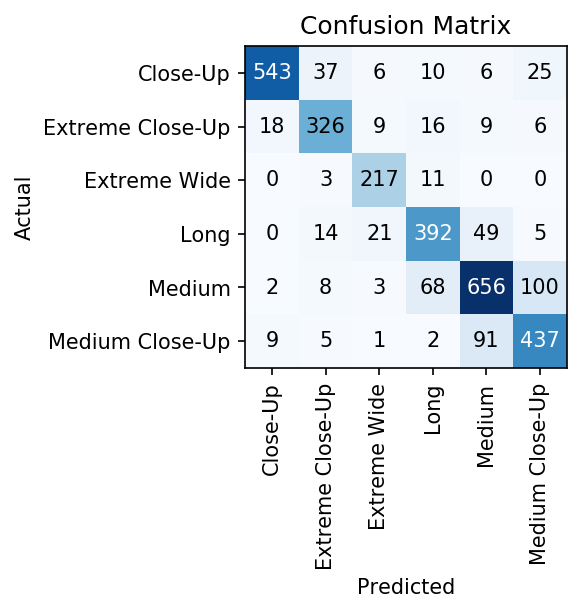

In [28]:
learn.fit_one_cycle(15, slice(1e-6, 3e-4), callbacks=callbacks)

In [33]:
config = wandb.config

config.img_size = img_size
config.batch_size = batch_size
config.len_train = len(learn.data.train_ds)
config.len_valid = len(learn.data.valid_ds)
config.model = 'MobileNet-V2'

Error generating diff: Command '['git', 'diff', '--submodule=diff', '747359307a168f411ffb9fcfe9d768f1d7920bfd']' timed out after 5 seconds


### Export to CoreML

In [47]:
from CinemaNet.convert import *
from CinemaNet.custom_head import *

In [48]:
model_name

'MNetV2-100x177-3000L-unfrozen'

In [60]:
learn = cnn_learner(data, arch)
learn.load(model_name);

In [62]:
model_fname='MNetV2-100x177-3000L'

In [63]:
torch_to_coreml(learn.model, data.c,
                model_fname=model_fname,
                img_size=img_size)

1/162: Converting Node Type Conv
2/162: Converting Node Type BatchNormalization
3/162: Converting Node Type Clip
4/162: Converting Node Type Conv
5/162: Converting Node Type BatchNormalization
6/162: Converting Node Type Clip
7/162: Converting Node Type Conv
8/162: Converting Node Type BatchNormalization
9/162: Converting Node Type Conv
10/162: Converting Node Type BatchNormalization
11/162: Converting Node Type Clip
12/162: Converting Node Type Conv
13/162: Converting Node Type BatchNormalization
14/162: Converting Node Type Clip
15/162: Converting Node Type Conv
16/162: Converting Node Type BatchNormalization
17/162: Converting Node Type Conv
18/162: Converting Node Type BatchNormalization
19/162: Converting Node Type Clip
20/162: Converting Node Type Conv
21/162: Converting Node Type BatchNormalization
22/162: Converting Node Type Clip
23/162: Converting Node Type Conv
24/162: Converting Node Type BatchNormalization
25/162: Converting Node Type Add
26/162: Converting Node Type Conv


In [67]:
!ls -l ../exported-models/{model_fname}*

-rw-rw-r-- 1 rahul rahul 14346831 Jan 21 01:37 ../exported-models/MNetV2-100x177-3000L.mlmodel
-rw-rw-r-- 1 rahul rahul 14357316 Jan 21 01:37 ../exported-models/MNetV2-100x177-3000L.onnx


In [68]:
wandb.save(f'../exported-models/{model_fname}*')

Error generating diff: Command '['git', 'diff', '--submodule=diff', '747359307a168f411ffb9fcfe9d768f1d7920bfd']' timed out after 5 seconds


['/home/rahul/github_projects/CinemaNet/nbs/wandb/run-20200120_193037-smlfztc7/MNetV2-100x177-3000L.mlmodel',
 '/home/rahul/github_projects/CinemaNet/nbs/wandb/run-20200120_193037-smlfztc7/MNetV2-100x177-3000L.onnx']

### Export

In [5]:
from nbdev.export import *
notebook2script()

Converted 01_fastai_custom_head.ipynb.
Converted 02_wandb_callback.ipynb.
Converted 03_pytorch_to_coreml.ipynb.
Converted 04_mobilenet_v2_basic.ipynb.
Converted 05-1-MNetV2-100x177-3000L.ipynb.
This cell doesn't have an export destination and was ignored:
e
This cell doesn't have an export destination and was ignored:
e
This cell doesn't have an export destination and was ignored:
e
This cell doesn't have an export destination and was ignored:
e
This cell doesn't have an export destination and was ignored:
e
This cell doesn't have an export destination and was ignored:
e
Converted 05-1-MNetV2-150x266-3000L.ipynb.
Converted exploring-architectures.ipynb.
Converted mobilenetV3-large1.0-3000L.ipynb.
